# Inverting Gradients - How easy is it to break privacy in federated learning?

This notebook shows an example for a **single image gradient inversion** as described in "Inverting Gradients - How easy is it to break privacy in federated learning?". The setting is a pretrained ResNet-18 and the federated learning algorithm is **fedSGD**.

Paper URL: https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html

#### Abstract
The idea of federated learning is to collaboratively train a neural network on a server. Each user receives the current weights of the network and in turns sends parameter updates (gradients) based on local data. This protocol has been designed not only to train neural networks data-efficiently, but also to provide privacy benefits for users, as their input data remains on device and only parameter gradients are shared. But how secure is sharing parameter gradients? Previous attacks have provided a false sense of security, by succeeding only in contrived settings - even for a single image. However, by exploiting a magnitude-invariant loss along with optimization strategies based on adversarial attacks, we show that is is actually possible to faithfully reconstruct images at high resolution from the knowledge of their parameter gradients, and demonstrate that such a break of privacy is possible even for trained deep networks. We analyze the effects of architecture as well as parameters on the difficulty of reconstructing an input image and prove that any input to a fully connected layer can be reconstructed analytically independent of the remaining architecture. Finally we discuss settings encountered in practice and show that even averaging gradients over several iterations or several images does not protect the user's privacy in federated learning applications.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["attack=GAN"])
# cfg = breaching.get_config(overrides=['attack=hybrid_ac'])
          
device = torch.device(f'cuda:6') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=6), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="unique-class"
# cfg.case.data.partition="random"
cfg.case.user.user_idx = 2
# cfg.case.model='resnet50'
# cfg.case.model='resnet152'
cfg.case.model='resnet18'
cfg.case.server.pretrained = False

# cfg.case.data.examples_from_split='train'
cfg.case.data.examples_from_split='validation'

# cfg.attack.impl.sparse = 0.1
# cfg.attack.out_dir = "/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_descentWeightss_noise_5000_gaussian"
# cfg.attack.out_dir = "/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_cosin_descentWeights_"
# cfg.attack.out_dir = "/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_cosin_3000_"
# cfg.attack.out_dir = None
# cfg.attack.layer_weights = 'descentWeights'

# grad_scale=0.3
# cfg.attack.layer_weights = f'{cfg.case.model}_{grad_scale}_idx'
cfg.attack.layer_weights = None


cfg.attack.optim.optimizer='CMA'
cfg.attack.optim.callback = 100
# cfg.attack.optim.max_iterations=5000
# cfg.attack.regularization = None

# cfg.attack.optim.budget=2500
cfg.attack.optim.budget=500
cfg.attack.attack_type='optimization_GAN_CMA'

cfg.attack.optim.patched=None
# cfg.attack.init='zeros'
# cfg.attack.init="patterned-4"
# cfg.attack.optim.step_size_decay="cosine-decay"
# cfg.attack.out_dir = f"/home/zx/Gitrepo/breaching/out/channelgrad/{cfg.case.user.user_idx}_pattern_{cfg.attack.optim.patched}_decay_init_{cfg.attack.init}_sparse_"
# cfg.attack.out_dir = f"/home/zx/Gitrepo/breaching/out/patched/{cfg.case.user.user_idx}_pattern_{cfg.attack.optim.patched}_decay_init_{cfg.attack.init}_sparse_SignGradCosine_"
# cfg.attack.out_dir = f"/home/zx/Gitrepo/breaching/out/patched/{cfg.case.user.user_idx}_candidate_pattern_{cfg.attack.optim.patched}_decay_init_{cfg.attack.init}_sparse_"
cfg.attack.out_dir = f"/home/zx/Gitrepo/breaching/out/gradient_sparese/{cfg.case.user.user_idx}_GAN_{cfg.case.model}_random_model"
# cfg.attack.out_dir = "/home/zx/Gitrepo/breaching/out/gradient_sparese/optimization_IG_imgs_layerCosin_cosin_5000_2"


# cfg.attack.objective.type="layer-cosine-similariy"
# cfg.attack.objective.scale=0.1
# next(cfg.attack.regularization.keys())
# cfg.attack.out_dir
cfg.attack.type

'optimization_GAN'

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)
# print(model)

/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<class 'torch.jit._script.RecursiveScriptModule'>
Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 24
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker NGReconstructor with budget 500


In [5]:
# import time
# device = torch.device('cuda:1')
# data = torch.randn((1,3,224, 224)).to(device)
# model_test = model.to(device)

# st = time.time()
# model_test(data)

# print(time.time() - st)

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 24 in model mode: eval.


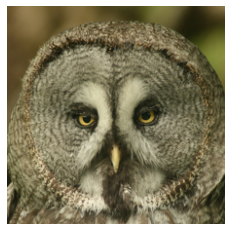

In [7]:
user.plot(true_user_data)
# from operator import index
# import torchvision
# from PIL import Image
# model = torchvision.models.resnet18()

# model = server.model.to(device=setup['device'])
# loss_fn = torch.nn.CrossEntropyLoss()
# label = torch.tensor([24], device=setup['device'])

# img  = Image.open('/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_cosin_5000_None/4500_0.png')
# img = torchvision.transforms.ToTensor()(img).unsqueeze(0).to(device=setup['device'])

# # transforms = [torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)), torchvision.transforms.RandomRotation(degrees=(0, 180)),  torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0), torchvision.transforms.ColorJitter(brightness=0.5, hue=0.3)]
# transforms = [torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0), torchvision.transforms.ColorJitter(brightness=0.5, hue=0.3)]
# transforms = [torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0)]

# reconstruction_imgs =breaching.utils.get_imgs_from_dir('/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_5000None', device=setup['device'])


# compare_fn = torch.nn.MSELoss()
# compare_fn = breaching.utils.l2_norm
# compare_fn = breaching.utils.cosin_similarity

# sensitives_by_augmentation = breaching.utils.grad_sensitive_from_transformaiton(model, img, loss_fn, label, transforms, compare_fn)
# sensitives_by_recosntruction = breaching.utils.grad_sensitive_from_reconstruction(model, img, loss_fn, label, reconstruction_imgs, compare_fn)

# indexs = []
# import math

# for sens in  breaching.utils.show_sensitives(sensitives_by_augmentation):
#     indexs.append(sens[:math.ceil(grad_scale * len(sens))])
#     print(sens.shape)

# index = torch.unique(torch.cat(indexs)) 
# print(index.dtype)
# torch.save(index,f'/home/zx/Gitrepo/breaching/breaching/attacks/auxiliaries/{cfg.case.model}_{grad_scale}_idx' )


# for sens in  show_sensitives(sensitives_by_recosntruction):
#     print(sens)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [8]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)
generator= BigGAN.from_pretrained('biggan-deep-256').to(setup['device'])

loading model biggan-deep-256 from cache at /home/zx/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43
Model config {
  "attention_layer_position": 8,
  "channel_width": 128,
  "class_embed_dim": 128,
  "eps": 0.0001,
  "layers": [
    [
      false,
      16,
      16
    ],
    [
      true,
      16,
      16
    ],
    [
      false,
      16,
      16
    ],
    [
      true,
      16,
      8
    ],
    [
      false,
      8,
      8
    ],
    [
      true,
      8,
      8
    ],
    [
      false,
      8,
      8
    ],
    [
      true,
      8,
      4
    ],
    [
      false,
      4,
      4
    ],
    [
      true,
      4,
      2
    ],
    [
      false,
      2,
      2
    ],
    [
      true,
      2,
      1
    ]
  ],
  "n_stats": 51,
  "num_classes": 1000,
  "output_dim": 256,
  "z_dim": 128
}



In [9]:
# %%capture cap --no-stderr
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], generator=generator, dryrun=False)

Recovered labels [24] through strategy bias-corrected.
Inferred label: tensor([24], device='cuda:6')


Loss 1.17024: 100%|██████████| 500/500 [29:45<00:00,  3.57s/it]


In [10]:
# with open(cfg.attack.out_dir + 'None/log', 'w') as f:
#     f.write(cap.stdout)

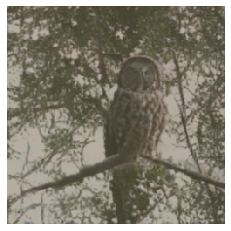

In [11]:

user.plot(reconstructed_user_data)

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [12]:
# %%capture cap --no-stderr
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zx/miniconda3/envs/torch1.12/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


METRICS: | MSE: 0.0397 | PSNR: 14.01 | FMSE: 5.7841e-03 | LPIPS: 0.64|
 R-PSNR: 14.56 | IIP-pixel: 0.00% | SSIM: 0.3412 | max R-PSNR: 14.56 | max SSIM: 0.3412 | Label Acc: 100.00%


In [13]:

# with open(cfg.attack.out_dir + 'None/log', 'a') as f:
#     f.write(cap.stdout)

In [14]:

# ## save paraemters

# %load_ext autoreload
# # %reload_ext autoreload
# %autoreload 2
# from xml.dom.minidom import ReadOnlySequentialNamedNodeMap


# # path = '/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_5000None/' + name
# # path = '/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_cosin_2None/' + name
# # path = '/home/zx/Gitrepo/breaching/out/optimization_IG_imgs_noise_cosin_5000_None/' + name
# # imgs_name = ['0_0.png', '1000_0.png', '2000_0.png', '3000_0.png', '4000_0.png']

# imgs_name = ['0_0.png', '1000_0.png', '5000_0.png', '9000_0.png', '10000_0.png', '15000_0.png', '20000_0.png', '23999_0.png']
# imgs_name = ['23999_0.png']
# img_dir = '/home/zx/Gitrepo/breaching/out/optimization_GI_imgs_noise_None/' 

# def image_measure(img_name, img_dir,reconstructed_user_data, true_user_data, server_payload, server, order_batch, compute_full_iip, cfg_case, setup,  dataset='ImageNet'):

#     from PIL import Image
#     import torch
#     import torchvision
#     import collections

#     result = collections.defaultdict(dict)
#     mean = [0.485, 0.456, 0.406] 
#     std = [0.229, 0.224, 0.225]

#     for name in imgs_name:

#         path = img_dir + name 
#         img = torchvision.transforms.ToTensor()(Image.open(path)).to(torch.float32).to(setup['device'])
#         img = torchvision.transforms.Normalize(mean, std)(img)
#         img = img.unsqueeze(0)

#         reconstructed_user_data['data'] = img

#         metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
#                                         server.model, order_batch=order_batch, compute_full_iip=compute_full_iip, 
#                                         cfg_case=cfg_case, setup=setup)
        
#         result[name] = metrics 


# image_measure(imgs_name, img_dir, reconstructed_user_data, true_user_data, server_payload, server, order_batch=True, compute_full_iip=False, cfg_case=cfg.case, setup=setup)

And finally, we also plot the reconstructed data:

In [15]:
# user.plot(reconstructed_user_data)

### Notes:
* The learning rate schedule for this attack is chosen with no regards for efficiency, for many use cases the learning rate can be increased and the number of steps decreased to speed up computations somewhat.
* The original paper included multiple trials of the attack (which can be enabled via `attack.restarts.num_trials=8`, but the attack already takes long enough for the ImageNet-sized example shown here.
* The model shown here is also a ResNet-18, which is noticeably smaller than the ResNet-152 used in e.g. Fig.3 of the Inverting Gradients paper (which can be loaded with `case.model=resnet152`).
* The original paper considered labels to be known. Here, we replace this explicit assumption by a modern label recovery algorithm (a variation of https://arxiv.org/abs/2105.09369)
* In this use case, there are no batch norm buffers shared by the user with the server. The server sends out pretrained batch norm statistics to all users (from a public pretrained model), and the users compute their update in evaluation mode.